<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/LengthScaleTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!cd drive

In [3]:
!pip install gpytorch
!pip install botorch

In [4]:
import sys
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, standardize
from botorch.fit import fit_gpytorch_mll
from tqdm import tqdm
torch.cuda.empty_cache()


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
base_path = "/content/drive/My Drive/Colab Notebooks/Transfer_Coh2"

For plotting the surface:

In [6]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device)).cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

Loading the full dataset:

In [7]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"{base_path}/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row : (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks data into a tensor
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [8]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [9]:
def normalize_standarize_data(x, y):
  '''
  x: unnormalized input to GP, inputs are normalized to be between 0, 2150
  y: not standardized outputs
  '''
  if x.shape[-1] == 2:
    c_xtrain = normalize(x[:, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
    y_train_standardized = standardize(y).reshape(-1,1)
    return c_xtrain, y_train_standardized
  elif x.shape[-1] == 3:
    d_xtrain = x[:,0].reshape(-1,1) #discrete part
    c_xtrain = normalize(x[:, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
    x_train_normalized = torch.cat([c_xtrain, d_xtrain], dim=1)
    y_train_standardized = standardize(y).reshape(-1,1)
    return x_train_normalized, y_train_standardized

  return None, None #doesn't support other dimension inputs

In [10]:
tasks = ["narea", "sla", "pn", "ps"] #<- works with one but looks weird with multitask...
seed = 1234
split = 0.85
option_n = [i for i in range(100, 1000, 250)]
M = 1000

seeds = 2

In [11]:
#load task data and split
X, Y = loadTasks(tasks)

#split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)
#x_train, y_train = x_train[:option_n[-1], 1:], y_train[:option_n[-1]]
#x_test, y_test = x_test[:M, 1:], y_test[:M]

Small test to make sure the GP fitting works.

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


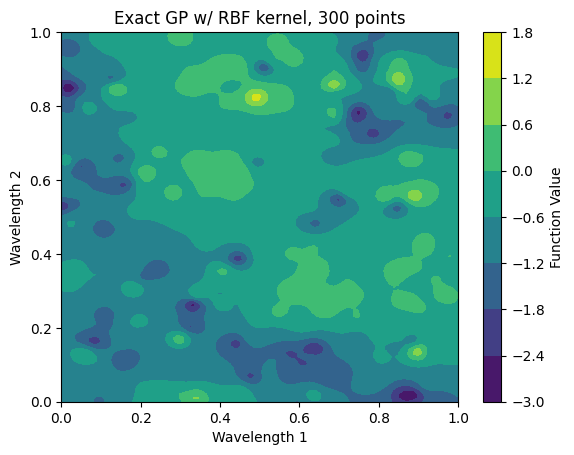

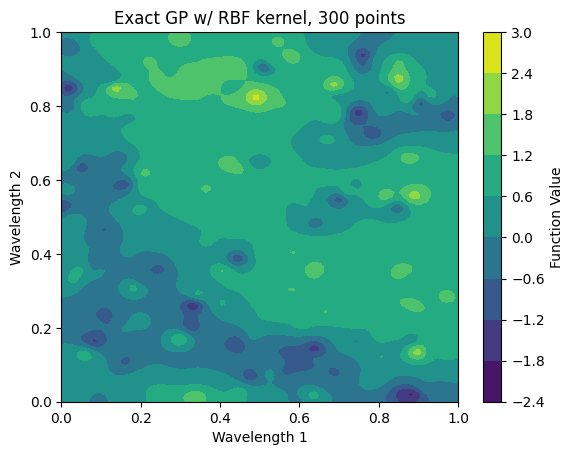

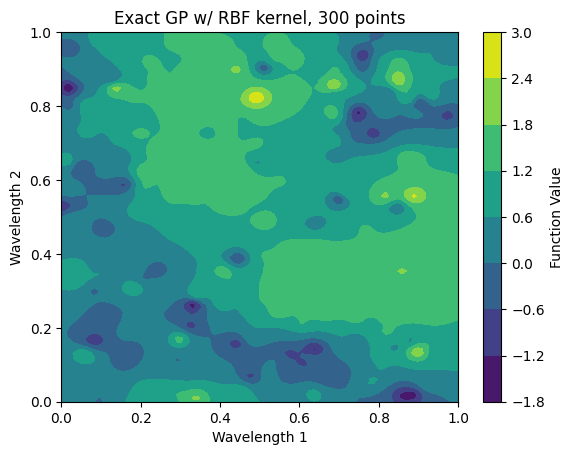

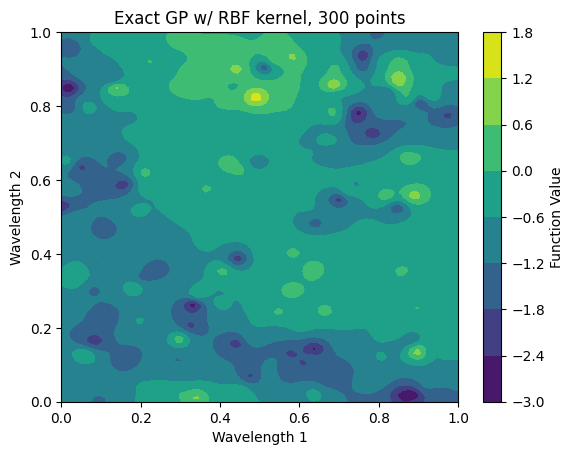

In [12]:
smoke_test = 1
if smoke_test:
    N = 300#option_n[-1]#500

    #standardize your data
    x_train_normalized, y_train_standardized = normalize_standarize_data(x_train[:N], y_train[:N])
    model = MixedSingleTaskGP(x_train_normalized, y_train_standardized, cat_dims=[-1])

    # Use Exact Marginal Log Likelihood as the loss
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Fit the model
    fit_gpytorch_mll(mll, )

    #get gaussian likelihood then it has object noise
    #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
    # print(f"noise: {model.likelihood.noise.item()}")

    # #Get the lengthscale
    # kernel = model.covar_module.base_kernel
    # print(f"lengthscale: {kernel.lengthscale.detach()}")
    for task in tasks:
      def modelWrapper(X):
        id = getTaskID(task)
        id_vector = id * torch.ones((X.shape[0],1))
        inp = torch.cat([X, id_vector], dim=1)
        return model.posterior(inp).mean
      surfacePlot(modelWrapper, title=f"Exact GP w/ RBF kernel, {N} points", n=100)

Run GP fitting on various levels of random points while keeping track of infered lengthscale and noise scales.

In [13]:
def getLengthscale(model):
  return model.covar_module.base_kernel.lengthscale.detach()[0]

def getNoise(model):
  return model.likelihood.noise.item()

In [14]:
seeds = 5

experiments = {}
for name, param in model.named_parameters():
  experiments[name] = [[] for i in range(seeds)]

for s in range(seeds):
  models = []


  #load task data and split
  X, Y = loadTasks(tasks)

  #split into training and test sets
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed+s)
  #x_train, y_train = x_train[:option_n[-1], 1:], y_train[:option_n[-1]]
  #x_test, y_test = x_test[:M, 1:], y_test[:M]

  for N in tqdm(option_n):
    torch.cuda.empty_cache()

    #standardize your data
    x_train_normalized, y_train_standardized = normalize_standarize_data(x_train[:N], y_train[:N])

    #model = SingleTaskGP(x_train_normalized, y_train_standardized)
    model = MixedSingleTaskGP(x_train_normalized, y_train_standardized, cat_dims=[-1])

    # Use Exact Marginal Log Likelihood as the loss
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Fit the model
    fit_gpytorch_mll(mll, )

    #get gaussian likelihood then it has object noise
    #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
    # print(f"noise: {model.likelihood.noise.item()}")

    #Get the lengthscale
    # kernel = model.covar_module.base_kernel
    # print(f"lengthscale: {kernel.lengthscale.detach()}")

    models.append(model)

    #track hyperparameters
    for name, param in model.named_parameters():
      experiments[name][s].append(param.data.reshape(1,-1))

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
 25%|██▌       | 1/4 [00:00<00:01,  2.01it/s]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
 50%|█████     | 2/4 [00:04<00:05,  2.70s/it]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
 75%|███████▌  | 3/4 [00:23<00:10, 10.14s/it]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube.

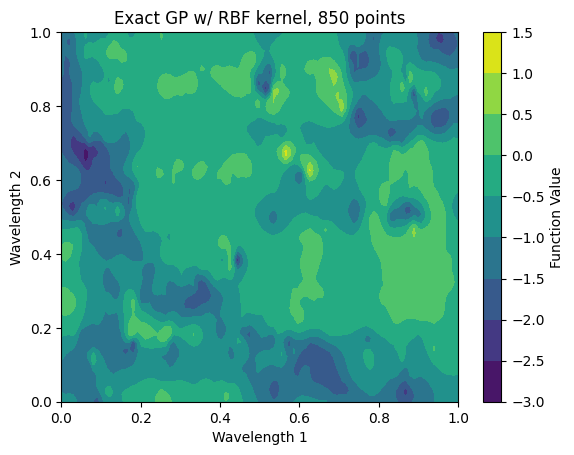

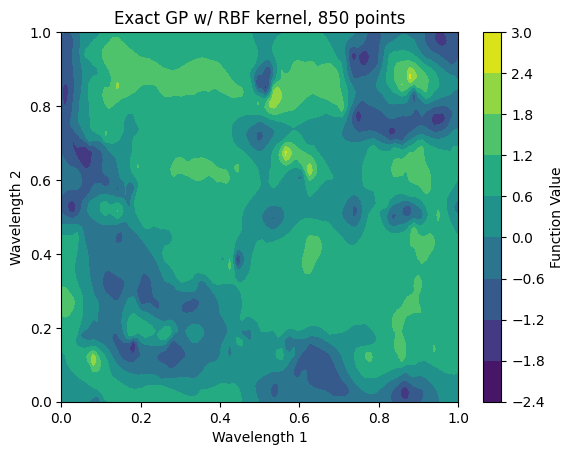

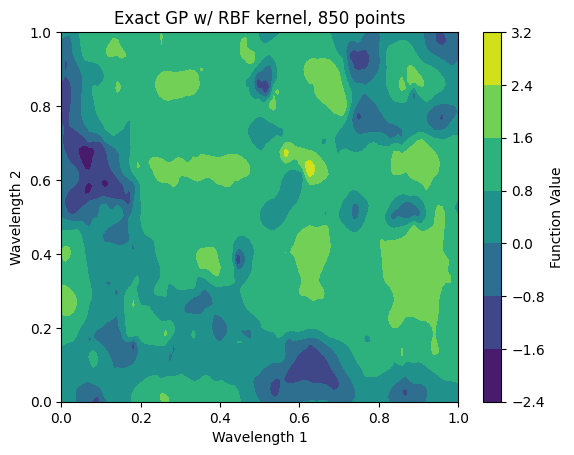

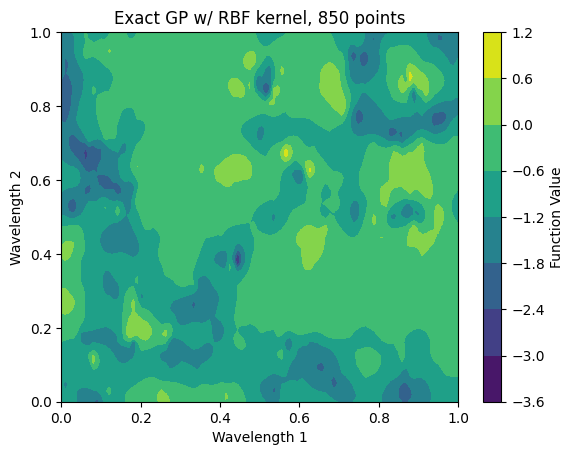

In [15]:
for task in tasks:
  def modelWrapper(X):
    id = getTaskID(task)
    id_vector = id * torch.ones((X.shape[0],1))
    inp = torch.cat([X, id_vector], dim=1)
    return model.posterior(inp).mean
  surfacePlot(modelWrapper, title=f"Exact GP w/ RBF kernel, {N} points", n=100)

In [16]:
for name, param in model.named_parameters():
  print(name, param.shape)

likelihood.noise_covar.raw_noise torch.Size([1])
mean_module.raw_constant torch.Size([])
covar_module.kernels.0.raw_outputscale torch.Size([])
covar_module.kernels.0.base_kernel.kernels.0.raw_lengthscale torch.Size([1, 2])
covar_module.kernels.0.base_kernel.kernels.1.raw_outputscale torch.Size([])
covar_module.kernels.0.base_kernel.kernels.1.base_kernel.raw_lengthscale torch.Size([1, 1])
covar_module.kernels.1.raw_outputscale torch.Size([])
covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale torch.Size([1, 2])
covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale torch.Size([1, 1])


In [17]:
feature_1d = ['likelihood.noise_covar.raw_noise',
              'mean_module.raw_constant',
              'covar_module.kernels.0.raw_outputscale',
              'covar_module.kernels.0.base_kernel.kernels.1.raw_outputscale',
              'covar_module.kernels.0.base_kernel.kernels.1.base_kernel.raw_lengthscale',
              'covar_module.kernels.1.raw_outputscale',
              'covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale']

feature_2d = ['covar_module.kernels.0.base_kernel.kernels.0.raw_lengthscale',
              'covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale']

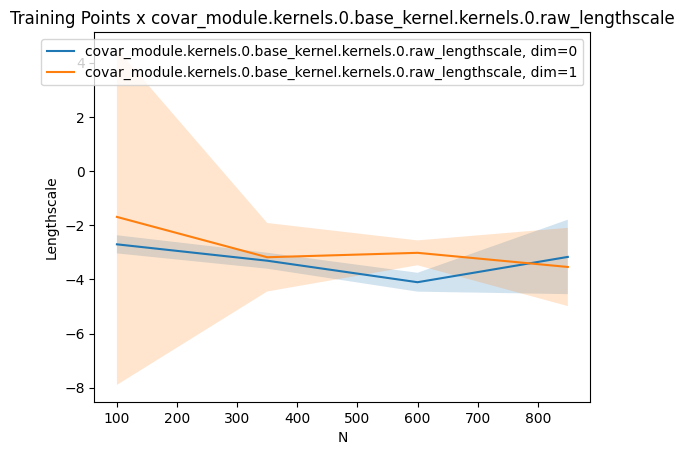

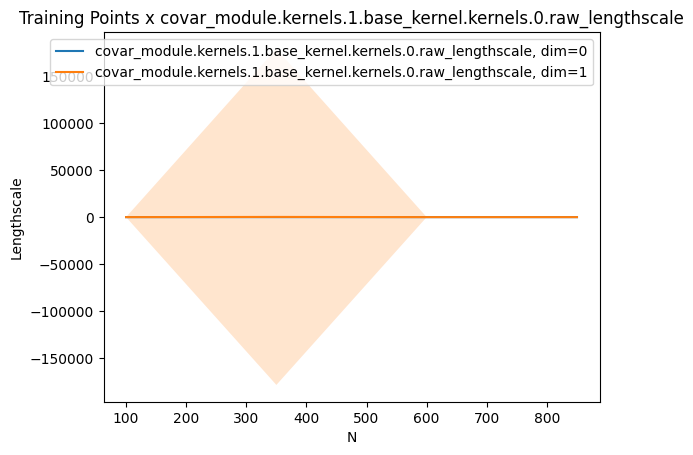

In [18]:
#plotting for lengthscale
for feature in feature_2d:
  temp = np.stack([torch.cat(item) for item in experiments[feature]], axis=1)

  # Compute mean and variance over seed
  mean = np.mean(temp, axis=1)
  var = np.var(temp, axis=1)

  # Plot Datasize to Length Scale relationship
  for dim in range(mean.shape[-1]):
      # Plot the mean
      plt.plot(option_n, mean[:,dim], label=f"{feature}, dim={dim}")

      # Fill between the upper and lower bounds for variance
      lower_bound = mean[:,dim] - var[:,dim]
      upper_bound = mean[:,dim] + var[:,dim]
      plt.fill_between(option_n, lower_bound, upper_bound, alpha=0.2)

  # Add labels and a title
  plt.xlabel('N')
  plt.ylabel(f'Lengthscale')
  plt.title(f'Training Points x {feature}')
  plt.legend()

  # Show the plot
  plt.show()

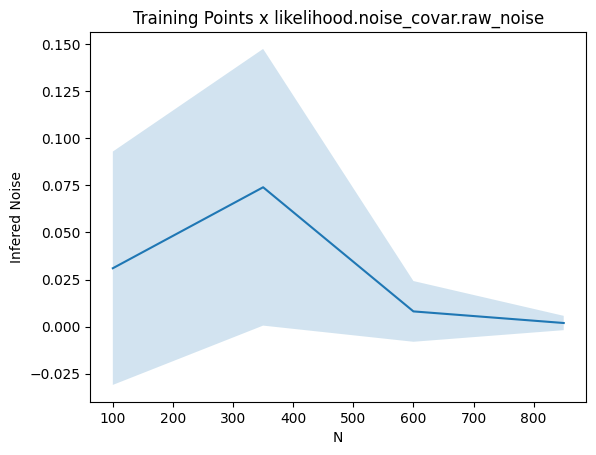

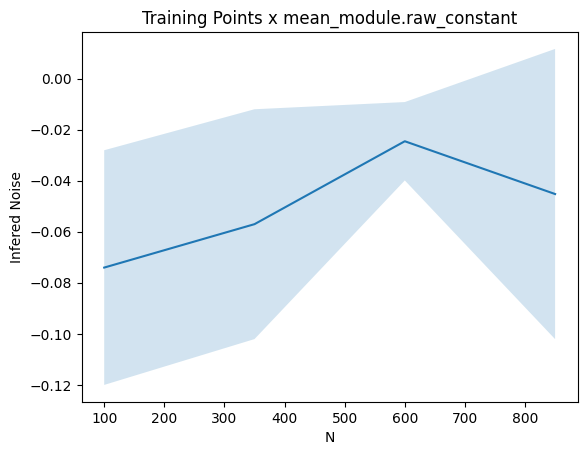

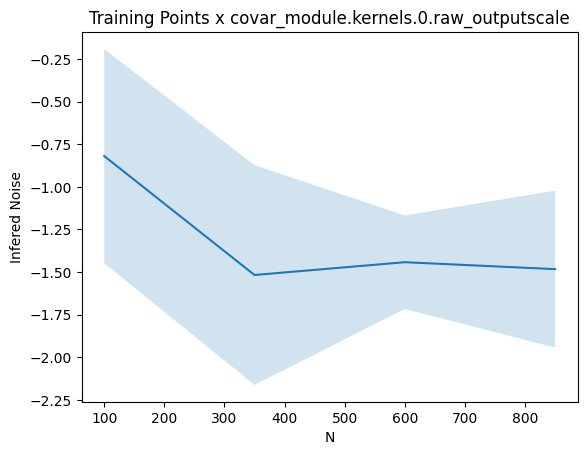

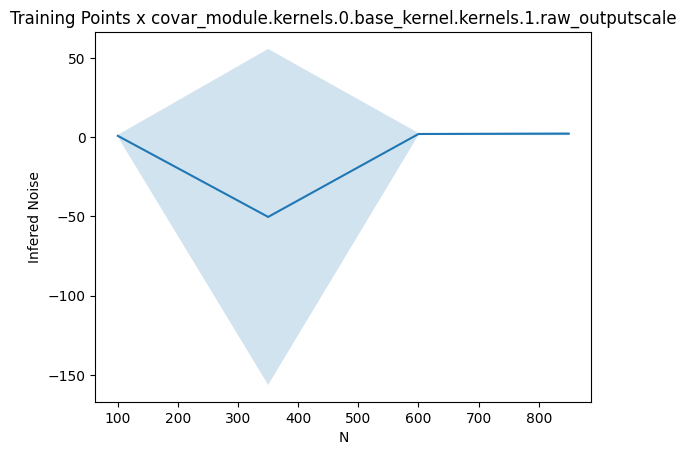

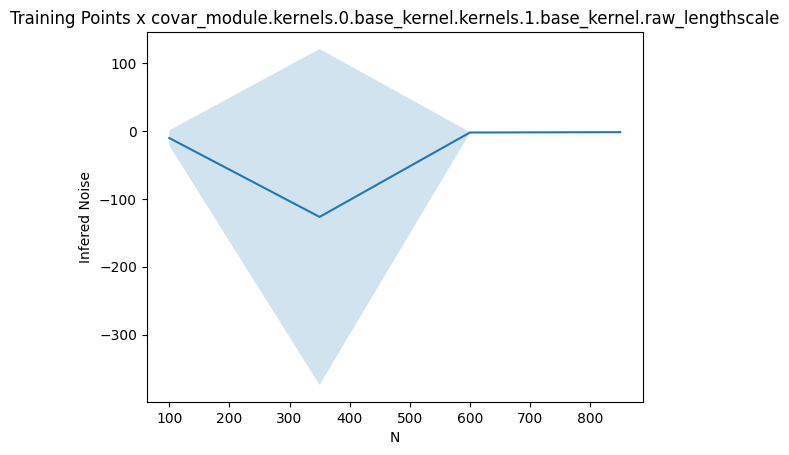

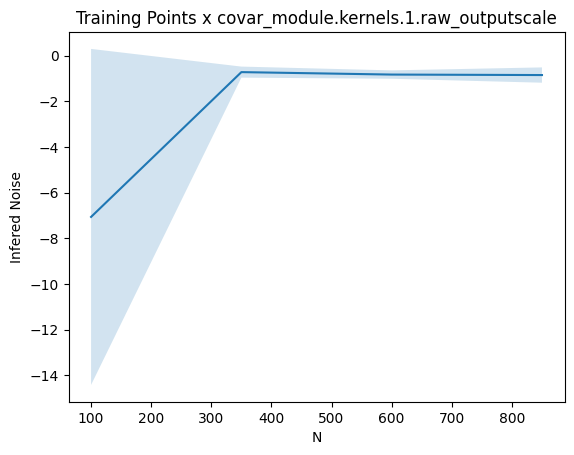

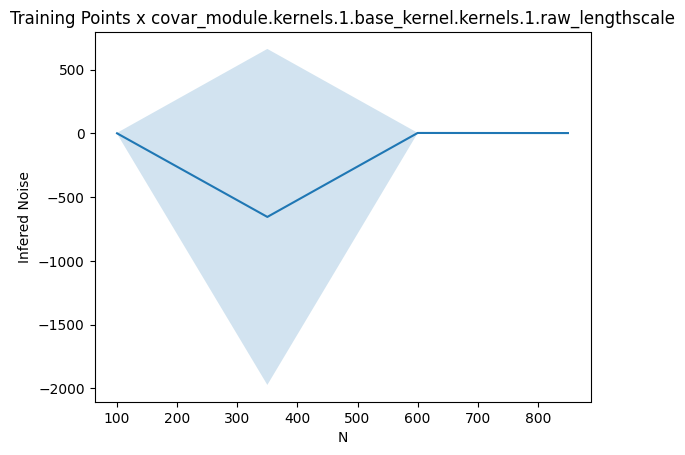

In [27]:
for feature in feature_1d:
  #plotting for noise
  temp = np.stack([torch.cat(item) for item in experiments[feature]], axis=0)

  # Compute mean and variance over seed
  mean = np.mean(temp, axis=0).flatten()
  std = np.std(temp, axis=0).flatten()

  # Plot the mean
  plt.plot(option_n, mean[:], label=f'{feature}')

  # Fill between the upper and lower bounds for variance
  lower_bound = mean[:] - std[:]
  upper_bound = mean[:] + std[:]
  plt.fill_between(option_n, lower_bound, upper_bound, alpha=0.2)

  # Add labels and a title
  plt.xlabel('N')
  plt.ylabel(f'Infered Noise')
  #plt.ylim([-10,10])
  plt.title(f'Training Points x {feature}')

  # Show the plot
  plt.show()

In [24]:
model

MixedSingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): AdditiveKernel(
          (kernels): ModuleList(
            (0): MaternKernel(
              (raw_lengthscale_constraint): GreaterThan(1.000E-04)
            )
            (1): ScaleKernel(
              (base_kernel): CategoricalKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-06)
              )
              (raw_outputscale_constraint): Positive()
            )
          )
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): ProductKernel(
          (kernels): ModuleList(
            (0): MaternKernel(
              (raw_lengthscale_constraint): GreaterThan(1.000E-04)
    